In [1]:
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
import shutil, os, random,cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from tensorflow.keras import layers, models, callbacks
from sklearn.model_selection import train_test_split, KFold

In [2]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# **1. Descargar y preparar conjunto de datos**

### Funciones anónimas para obtener las categorías de cada imágen

In [3]:
isStego=lambda x:1 if x[:6]=="stego_" else 0
getYFromImageList=lambda x: [isStego(element) for element in x]

In [4]:
folder="./MonoSamples/WOW_5/"

In [5]:
images=os.listdir(folder)
random.shuffle(images)
images=images[:22000]
print(len(images))

22000


In [7]:
len(images)

22000

### Orden aleatorio del dataset

### Obteniendo las categorías

In [8]:
y=np.array(getYFromImageList(images),dtype='float32')

In [9]:
y.shape

(22000,)

In [10]:
y

array([1., 1., 0., ..., 0., 0., 0.], dtype=float32)

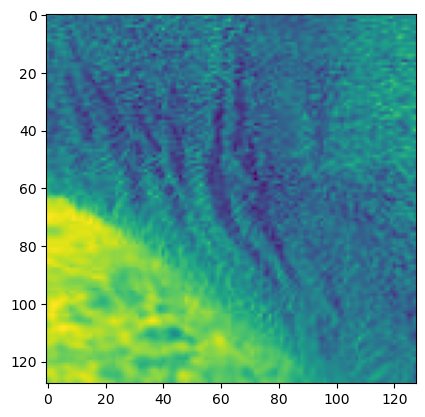

In [11]:
plt.imshow(mpimg.imread(folder+images[15]))
plt.show()

### Obteniendo data de x

In [12]:
import time

# Acá se usan 30GB de memoria (?) algo raro está pasando, de pronto hay que convertirlo a np array en otra línea. List comprehension usa mucha memoria...

In [13]:
#.reshape(49152)
#/255,dtype='int8'
#Editar tamaño de muestra
#Editar canal
import time
t = time.time()
x=np.array([mpimg.imread(folder+images[i]) for i in range(len(images))],dtype=np.float32)
print( time.time()-t)

15.965145111083984


In [14]:
import gc
gc.enable()
gc.garbage

[]

In [15]:
print(x.shape)

(22000, 128, 128)


# **3. Base Convolucional**

In [17]:
kf = KFold(n_splits=5, shuffle=False)
acc_per_fold = []
loss_per_fold = []

In [18]:
[[y[i],images[i]] for i in range(1,10)]

[[1.0, 'stego_393_n04553703_13369.JPEG'],
 [0.0, '874_n02783161_13715.JPEG'],
 [0.0, '12_n02013706_6141.JPEG'],
 [1.0, 'stego_555_n03792782_11043.JPEG'],
 [1.0, 'stego_515_n04286575_58765.JPEG'],
 [1.0, 'stego_263_n01687978_5069.JPEG'],
 [0.0, '825_n02168699_5366.JPEG'],
 [1.0, 'stego_586_n02988304_1985.JPEG'],
 [1.0, 'stego_590_n02788148_36564.JPEG']]

In [19]:
x=x.reshape(len(x),128,128,1)

In [20]:
gc.collect()

3524

In [21]:
x.shape

(22000, 128, 128, 1)

In [22]:
gc.collect()

0

In [23]:
x[0].shape

(128, 128, 1)

as [  0   1   2   3 252 253 254 255]


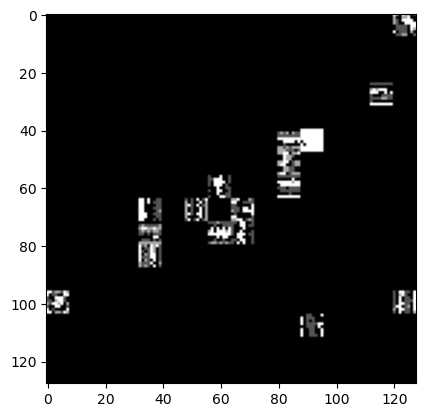

In [24]:
cover=mpimg.imread("cover1.JPEG")#[:,::-1]
stego=mpimg.imread("stego1.JPEG")#[:,::-1]
print("as",np.unique(cover-stego))
plt.imshow((cover-stego)*63,cmap='gray' )#(cover-stego)*255)#-stego)*255)
plt.show()

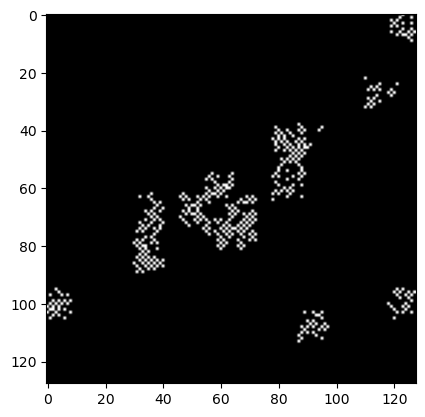

In [25]:
from scipy import ndimage
kernal=   np.array([
            [ -1,  2 ,  -2,  2 ,  -1],
            [ 2 , -6 ,  8 , -6 ,  2 ],
            [ -2,  8 , -12,  8 ,  -2 ],
            [ 2 , -6 ,  8 , -6 ,  2 ],
            [ -1,  2 ,  -2,  2 ,  -1]
        ],dtype = 'float')/12  
    
plt.imshow(ndimage.convolve(cover, kernal)-ndimage.convolve(stego, kernal),cmap='gray')#-ndimage.convolve(stego, kernal)
plt.show()

In [26]:
gc.collect()

6252

In [27]:
x=x.reshape(len(x),128,128,1)

# Acá también se usa mucha memoria

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/20
275/275 [==============================] - 1076s 4s/step - loss: 0.7346 - accuracy: 0.5056 - f1_m: 0.6660 - precision_m: 0.5019 - recall_m: 1.0000 - val_loss: 0.6931 - val_accuracy: 0.5057 - val_f1_m: 0.6673 - val_precision_m: 0.5034 - val_recall_m: 1.0000
Epoch 2/20
275/275 [==============================] - 1261s 5s/step - loss: 0.6931 - accuracy: 0.4927 - f1_m: 0.6657 - precision_m: 0.5020 - recall_m: 0.9990 - val_loss: 0.6931 - val_accuracy: 0.5009 - val_f1_m: 0.6671 - val_precision_m: 0.5033 - val_recall_m: 0.9995
Epoch 3/20
275/275 [==============================] - 1254s 5s/step - loss: 0.6931 - accuracy: 0.5032 - f1_m: 0.6657 - precision_m: 0.5018 - recall_m: 0.9987 - val_loss: 0.6931 - val_accuracy: 0.4970 - val_f1_m: 0.6673 - val_precision_m: 0.5034 - val_recall_m: 1.0000
Epoch 4/20
275/275 [==============================] - 944s 3s/step - loss: 0.6931 - accuracy: 0.496

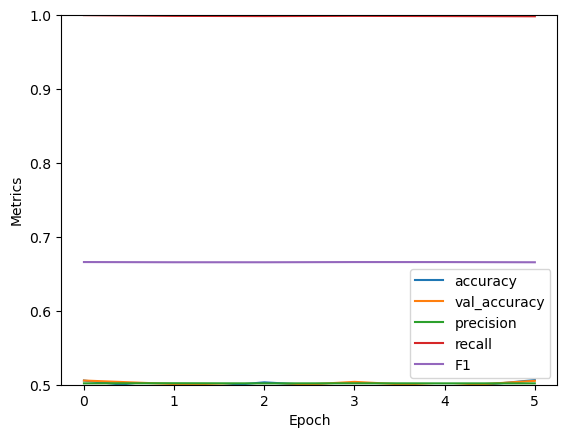

Next fold
Score for fold 1: loss of 0.6931462287902832; accuracy of 50.56818127632141%
------------------------------------------------------------------------
Training for fold 2 ...
Epoch 1/20
275/275 [==============================] - 805s 3s/step - loss: 7.2269 - accuracy: 0.4982 - f1_m: 0.6662 - precision_m: 0.5020 - recall_m: 1.0000 - val_loss: 7.6674 - val_accuracy: 0.4973 - val_f1_m: 0.6673 - val_precision_m: 0.5030 - val_recall_m: 1.0000
Epoch 2/20
275/275 [==============================] - 799s 3s/step - loss: 7.6687 - accuracy: 0.4980 - f1_m: 0.6661 - precision_m: 0.5020 - recall_m: 1.0000 - val_loss: 7.6688 - val_accuracy: 0.4973 - val_f1_m: 0.6673 - val_precision_m: 0.5030 - val_recall_m: 1.0000
Epoch 3/20
275/275 [==============================] - 801s 3s/step - loss: 7.6687 - accuracy: 0.4980 - f1_m: 0.6663 - precision_m: 0.5020 - recall_m: 1.0000 - val_loss: 7.6688 - val_accuracy: 0.4973 - val_f1_m: 0.6673 - val_precision_m: 0.5030 - val_recall_m: 1.0000
Epoch 4/20
275/

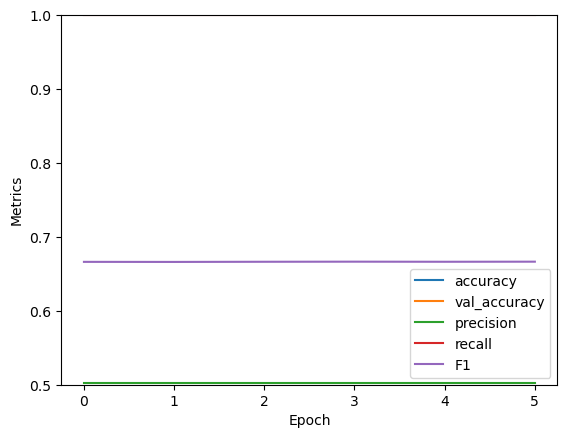

Next fold
Score for fold 2: loss of 7.667391777038574; accuracy of 49.72727298736572%
------------------------------------------------------------------------
Training for fold 3 ...
Epoch 1/20
275/275 [==============================] - 805s 3s/step - loss: 0.7619 - accuracy: 0.5055 - f1_m: 0.6702 - precision_m: 0.5066 - recall_m: 1.0000 - val_loss: 0.6931 - val_accuracy: 0.4845 - val_f1_m: 0.6502 - val_precision_m: 0.4845 - val_recall_m: 1.0000
Epoch 2/20
275/275 [==============================] - 798s 3s/step - loss: 0.6931 - accuracy: 0.5066 - f1_m: 0.6704 - precision_m: 0.5066 - recall_m: 1.0000 - val_loss: 0.6931 - val_accuracy: 0.4845 - val_f1_m: 0.6502 - val_precision_m: 0.4845 - val_recall_m: 1.0000
Epoch 3/20
275/275 [==============================] - 797s 3s/step - loss: 0.6931 - accuracy: 0.4978 - f1_m: 0.1873 - precision_m: 0.1415 - recall_m: 0.2800 - val_loss: 0.6931 - val_accuracy: 0.5155 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoc

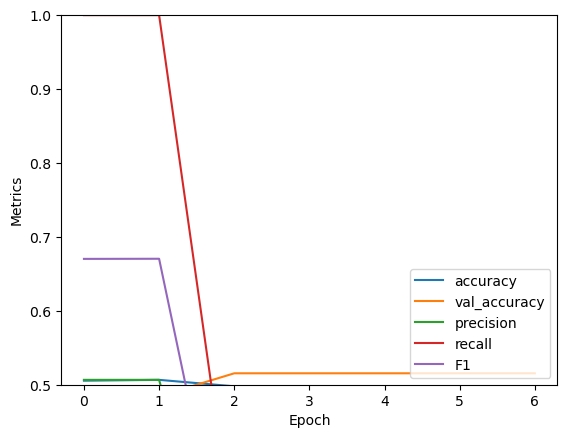

Next fold
Score for fold 3: loss of 0.6931462287902832; accuracy of 48.45454692840576%
------------------------------------------------------------------------
Training for fold 4 ...
Epoch 1/20
275/275 [==============================] - 794s 3s/step - loss: 0.6935 - accuracy: 0.4948 - f1_m: 0.5708 - precision_m: 0.4290 - recall_m: 0.8618 - val_loss: 0.6931 - val_accuracy: 0.4893 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/20
275/275 [==============================] - 797s 3s/step - loss: 0.6931 - accuracy: 0.4999 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 0.6931 - val_accuracy: 0.4893 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 3/20
275/275 [==============================] - 799s 3s/step - loss: 0.6931 - accuracy: 0.4999 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 0.6931 - val_accuracy: 0.4893 - val_f1_m: 0.0000e+00 - val_precis

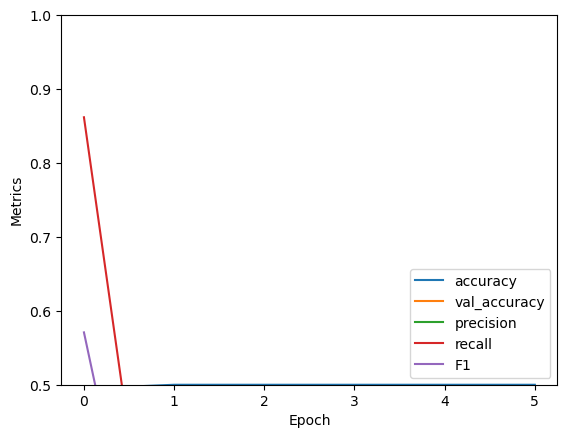

Next fold
Score for fold 4: loss of 0.6931462287902832; accuracy of 48.93181920051575%
------------------------------------------------------------------------
Training for fold 5 ...
Epoch 1/20
275/275 [==============================] - 806s 3s/step - loss: 7.6431 - accuracy: 0.4999 - f1_m: 0.6645 - precision_m: 0.5003 - recall_m: 1.0000 - val_loss: 7.6694 - val_accuracy: 0.4905 - val_f1_m: 0.6726 - val_precision_m: 0.5096 - val_recall_m: 1.0000
Epoch 2/20
275/275 [==============================] - 801s 3s/step - loss: 7.6686 - accuracy: 0.4997 - f1_m: 0.6647 - precision_m: 0.5003 - recall_m: 1.0000 - val_loss: 7.6694 - val_accuracy: 0.4905 - val_f1_m: 0.6726 - val_precision_m: 0.5096 - val_recall_m: 1.0000
Epoch 3/20
275/275 [==============================] - 798s 3s/step - loss: 7.6686 - accuracy: 0.4997 - f1_m: 0.6650 - precision_m: 0.5003 - recall_m: 1.0000 - val_loss: 7.6694 - val_accuracy: 0.4905 - val_f1_m: 0.6726 - val_precision_m: 0.5096 - val_recall_m: 1.0000
Epoch 4/20
275/

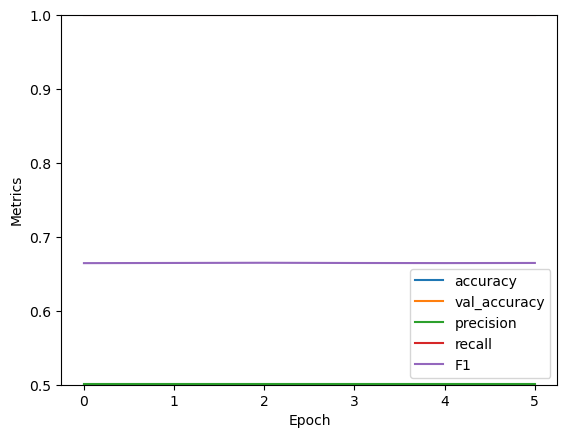

Next fold
Score for fold 5: loss of 7.669380187988281; accuracy of 49.04545545578003%


In [34]:
#Setting early stopping
earlystopping=callbacks.EarlyStopping(monitor="val_loss", mode="min",patience=5,restore_best_weights=True)
#Conv
fold_no = 1
for train, test in kf.split(x, y):
    model = models.Sequential()
    model.add(layers.Conv2D(128,(5,5), padding='valid',strides=[1, 1],
                      input_shape=(128, 128,1)))
    model.add(layers.MaxPooling2D((3, 3)))
    model.add(layers.Conv2D(256, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((3, 3)))
    model.add(layers.Conv2D(512, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((3, 3)))
    model.add(layers.Conv2D(1024, (3, 3), activation='relu'))
    #Dense
    model.add(layers.Flatten())#, activation='relu'
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(1024, activation='relu'))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(8, activation='relu'))
    model.add(layers.Dense(2, activation='softmax'))
    #Comp
    customSGD=tf.optimizers.SGD(learning_rate=0.015)
    customAdam=tf.optimizers.Adam(learning_rate=0.02)
    model.compile(optimizer=tf.optimizers.Adam(),
                  loss=tf.keras.losses.binary_crossentropy, 
                  metrics=['accuracy',f1_m,precision_m, recall_m])
        # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    #Fitting
    history = model.fit(x[train], y[train],validation_data=(x[test], y[test]), epochs=20, callbacks=[earlystopping],batch_size=64)
    gc.collect()
    print("\n\n\n\n\nFitted")
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0.5, 1])
    plt.legend(loc='lower right')
    test_loss, test_acc,f1_score, precision, recall = model.evaluate(x[test], y[test], verbose=2)
    print("Loss:",test_loss, "\nAccuracy:",test_acc,"\nF1 score:",f1_score, "\nPrecision:",precision, "\nRecall",recall)
        
    plt.plot(history.history['precision_m'], label='precision')
    plt.plot(history.history['recall_m'], label = 'recall')
    plt.plot(history.history['f1_m'], label = 'F1')
    plt.xlabel('Epoch')
    plt.ylabel('Metrics')
    plt.legend(loc='lower right')
    plt.show()
    print("Next fold")
    #dataMqtt={"Fold":str(fold_no),"timestamp":str(datetime.now()),"Loss":str(test_loss), "Acc":str(test_acc),"F1":str(f1_score),"Precision":str( precision),"Recall": str(recal)}
    #dataMqtt_out=json.dumps(data)
    #retMqtt= client1.publish("stegian/data",dataMqtt_out)
    
    # Generate generalization metrics
    scores = model.evaluate(x[test], y[test], verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    
    # Increase fold number
    fold_no += 1
    gc.collect()

In [ ]:
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

#model.build((None,128,128,3))
model.summary()

# **4. Agregar capas densas en la parte superior**

In [ ]:
model.summary()

# **5. Compilar y entrenar el modelo**



In [ ]:
model.save("CNNv2_Mono_WOW5.h5")

# **6. Evaluar el modelo**